In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy
import seaborn as sns
import ast
from collections import Counter

In [4]:
plt.style.use("seaborn-colorblind")
np.random.seed(seed=42)

# Prepare User Data

In [5]:
user_data_df = pd.read_csv("data/LFM-1b_users.txt", sep="\t")[["user_id", "country", "age", "gender"]].set_index("user_id")
user_data_df.head()

,country,age,gender
user_id,,,
384,UK,35,m
1206,NaN,-1,n
2622,NaN,-1,NaN
2732,NaN,-1,n
3653,UK,31,m


In [6]:
user_data_add_df = pd.read_csv("data/LFM-1b_users_additional.txt", sep="\t").set_index("user-id")
user_data_add_df = user_data_add_df[["cnt_listeningevents"]]
user_data_add_df.head()

,cnt_listeningevents
user-id,
384,17198
1206,17967
2622,3939
2732,234
3653,18238


In [7]:
user_mainstreaminess_df = pd.read_csv("data/user_mainstreaminess.txt", sep="\t").set_index("user_id")
user_mainstreaminess_df = user_mainstreaminess_df[["M_global_R_APC"]]
user_mainstreaminess_df.head()

,M_global_R_APC
user_id,
6823936,0.232189
2349062,0.205346
33220616,0.327310
5535755,0.040793
8861713,0.210598


In [8]:
data_df = user_data_df.merge(user_data_add_df, left_index=True, right_index=True).merge(user_mainstreaminess_df, left_index=True, right_index=True)
data_df.dropna(inplace=True)
data_df.head()

,country,age,gender,cnt_listeningevents,M_global_R_APC
user_id,,,,,
384,UK,35,m,17198,0.166818
3653,UK,31,m,18238,0.192014
4813,US,43,m,868,0.096758
5069,AT,30,m,17732,0.251059
5213,UK,37,n,802,0.256085


# Listening Event Kernel Density Estimation

Text(0, 0.5, 'Density')

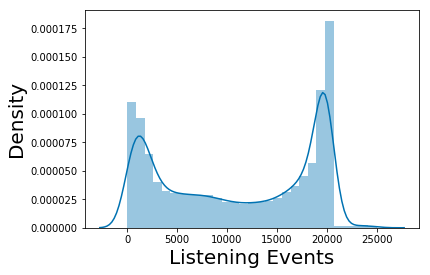

In [9]:
listening_events = data_df[data_df['cnt_listeningevents'] <= 25000]['cnt_listeningevents']
LE_kde = sns.distplot(listening_events).get_lines()[0].get_data()
plt.xlabel('Listening Events', fontsize=20)
plt.ylabel('Density', fontsize=20)

In [10]:
LE_kde_df = pd.DataFrame(LE_kde).T
LE_kde_df.columns = ["x", "y"]
LE_kde_df.head()

,x,y
0,-2765.918720,1.603734e-07
1,-2525.463307,3.583183e-07
2,-2285.007894,7.570544e-07
3,-2044.552481,1.506490e-06
4,-1804.097068,2.823188e-06


# Listening Events Threshold

In [11]:
LE_gradient = np.gradient(LE_kde_df["y"])

In [12]:
indices = np.where(np.abs(LE_gradient) < 0.000001)[0]
longest_seq, current_seq = [], []
for v in indices:
    if len(current_seq) == 0:
        current_seq.append(v)
    else:
        if current_seq[-1] == v-1:
            current_seq.append(v)
        elif len(longest_seq) < len(current_seq):
            longest_seq = current_seq
            current_seq = [v]

print("The longest consecutive sequence of points with a gradient < 0.000001 goes from %d to %d" % (LE_kde_df.iloc[longest_seq[0]]["x"], LE_kde_df.iloc[longest_seq[-1]]["x"]))

The longest consecutive sequence of points with a gradient < 0.000001 goes from 4688 to 14787


Text(0.5, 0, 'Number of listening events per user')

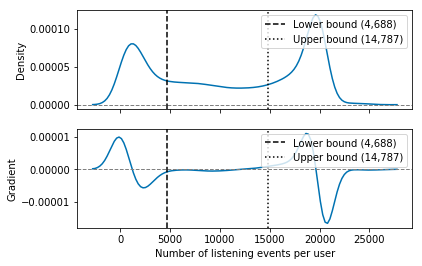

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(LE_kde_df["x"], LE_kde_df["y"], label="")
axes[0].axhline(y=0, linestyle="--", color="grey", linewidth=1)
axes[0].axvline(x=4688, linestyle="--", c="black", label="Lower bound (4,688)")
axes[0].axvline(x=14787, linestyle="dotted", c="black", label="Upper bound (14,787)")
axes[0].legend(loc="upper right")
axes[0].set_ylabel("Density")
axes[0].grid(False)

axes[1].plot(LE_kde_df["x"], LE_gradient, label="")
axes[1].axhline(y=0, linestyle="--", color="grey", linewidth=1)
axes[1].axvline(x=4688, linestyle="--", c="black", label="Lower bound (4,688)")
axes[1].axvline(x=14787, linestyle="dotted", c="black", label="Upper bound (14,787)")
axes[1].set_ylabel("Gradient")
axes[1].grid(False)
axes[1].legend(loc="upper right")

plt.xlabel("Number of listening events per user")

# Mainstreaminess Kernel Density Estimation

Text(0, 0.5, 'Density')

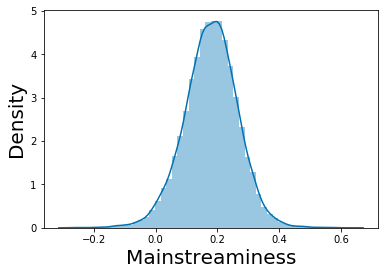

In [14]:
within_LE_thresh_df = data_df[(data_df["cnt_listeningevents"] >= 4688) & (data_df["cnt_listeningevents"] <= 14787)]['M_global_R_APC']
M_kde = sns.distplot(within_LE_thresh_df, kde=True).get_lines()[0].get_data()
plt.xlabel('Mainstreaminess', fontsize=20)
plt.ylabel('Density', fontsize=20)

In [15]:
M_kde_df = pd.DataFrame(M_kde).T
M_kde_df.columns = ["x", "y"]
M_kde_df.head()

,x,y
0,-0.313671,0.000028
1,-0.305909,0.000130
2,-0.298147,0.000488
3,-0.290384,0.001331
4,-0.282622,0.002717


# Mainstreaminess Threshold

In [16]:
M_gradient = np.gradient(M_kde_df["y"])
max_gradient = M_kde_df.iloc[np.argmax(M_gradient)]["x"]
print("The point with the maximal gradient is %f" % max_gradient)

The point with the maximal gradient is 0.097732


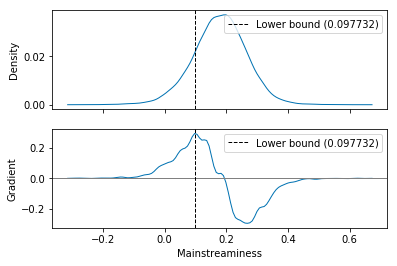

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(M_kde_df["x"], M_kde_df["y"] / len(M_kde_df), label="", linewidth=1)
axes[0].axvline(x=0.097732, linestyle="--", c="black", label="Lower bound (0.097732)", linewidth=1)
axes[0].set_ylabel("Density")
axes[0].grid(False)
axes[0].legend(loc="upper right")

axes[1].plot(M_kde_df["x"], M_gradient, linewidth=1)
axes[1].axhline(y=0, linestyle="-", c="grey", linewidth=1)
axes[1].axvline(x=0.097732, linestyle="--", c="black", label="Lower bound (0.097732)", linewidth=1)
axes[1].set_ylabel("Gradient")
axes[1].grid(False)
plt.xlabel("Mainstreaminess")
plt.legend(loc="upper right")

# Construction of BeyMS and MS

In [18]:
within_LE_thresh_df = data_df[(data_df["cnt_listeningevents"] >= 4688) & (data_df["cnt_listeningevents"] <= 14787)]
beyms = within_LE_thresh_df[within_LE_thresh_df["M_global_R_APC"] < 0.097732].index.tolist()
ms = np.random.choice(within_LE_thresh_df[within_LE_thresh_df["M_global_R_APC"] >= 0.097732].index.tolist(), size=len(beyms), replace=False).tolist()
print("We select only %.2f%% of users" % ((len(beyms) / len(within_LE_thresh_df)) * 100))

We select only 16.19% of users


In [19]:
list_of_tuples = []
chunksize = 10**6
for chunk in pd.read_csv("data/events.tsv", sep="\t", chunksize=chunksize):
    subchunk = chunk[chunk["user_id"].isin(beyms+ms)]
    data_tuples = [(user_id, artist_id, album_id, track_id, timestamp) for _, user_id, artist_id, album_id, track_id, timestamp in subchunk.itertuples()]
    list_of_tuples.extend(data_tuples)

In [20]:
events_df = pd.DataFrame.from_records(list_of_tuples, columns=["user_id", "artist_id", "album_id", "track_id", "timestamp"])
events_df.head()

,user_id,artist_id,album_id,track_id,timestamp
0,31435741,21,31,53,1370977938
1,31435741,21,31,53,1370977728
2,31435741,21,31,53,1370977518
3,31435741,21,31,53,1370977308
4,31435741,21,31,53,1370977098


# Identification of too-general Genres

In [21]:
acoustic_features_df = pd.read_csv("data/acoustic_features_lfm_id.tsv", sep="\t").set_index("track_id")
acoustic_features_df = acoustic_features_df[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "tempo", "valence", "liveness"]]
acoustic_features_df.dropna(inplace=True)
af_annotations = acoustic_features_df.index.tolist()

In [22]:
genre_annotations_df = pd.read_csv("data/genre_annotations.csv")
genre_annotations_df.columns = ["track_id", "genres"]
genre_annotations_df.set_index("track_id", inplace=True)
genre_annotations_df["genres"] = genre_annotations_df["genres"].apply(ast.literal_eval)
genre_annotations_df = genre_annotations_df[genre_annotations_df["genres"].apply(len) != 0]

In [23]:
len(genre_annotations_df)

320504

In [24]:
tracks = events_df[events_df["user_id"].isin(beyms)]["track_id"].unique().tolist()
relevant_tracks = set(tracks).intersection(genre_annotations_df.index).intersection(af_annotations)
beyms_genre_annotations_df = genre_annotations_df[genre_annotations_df.index.isin(relevant_tracks)].copy()

In [25]:
n_documents = len(relevant_tracks)
n_documents

163105

In [26]:
unique_genres = set()
for genres in beyms_genre_annotations_df["genres"]:
    unique_genres = unique_genres.union(genres)
len(unique_genres)

1424

In [27]:
beyms_genre_annotations_df["genres"] = beyms_genre_annotations_df["genres"].apply(lambda r: Counter(set(r)))
n_rel_docs = Counter(dict.fromkeys(unique_genres, 0))
for _, counts in beyms_genre_annotations_df.iterrows():
    n_rel_docs = Counter(n_rel_docs + counts.values[0])
n_rel_docs

Counter({'pop': 34521,
         'rock': 64213,
         'pianorock': 1353,
         'jazz': 9007,
         'singersongwriter': 18535,
         'neosoul': 1663,
         'alternativerock': 28668,
         'soul': 8875,
         'indierock': 23672,
         'blues': 6797,
         'rb': 3455,
         'indiepop': 12236,
         'electronic': 29644,
         'shoegaze': 3672,
         'electronica': 14532,
         'downtempo': 9264,
         'ambient': 15581,
         'dreampop': 4087,
         'experimental': 17010,
         'minimal': 2314,
         'lofi': 4858,
         'triphop': 6975,
         'postpunk': 6323,
         'drama': 273,
         'chillgroove': 97,
         'lounge': 6590,
         'poprock': 11338,
         'newwave': 5371,
         'indietronica': 3218,
         'contemporaryfolk': 363,
         'indiefolk': 3643,
         'bluegrass': 597,
         'banjo': 516,
         'country': 4744,
         'folkrock': 6947,
         'folk': 16342,
         'soundtrack': 6929

In [28]:
idf_scores = {genre: np.log10(n_documents / n_rel) for genre, n_rel in dict(n_rel_docs).items()}
idf_scores_df = pd.DataFrame.from_dict(idf_scores, orient="index", columns=["idf"]).sort_values(by="idf", ascending=True)
idf_scores_df.head(16)

,idf
rock,0.404844
pop,0.674384
metal,0.719958
electronic,0.740530
alternativerock,0.755070
indierock,0.838232
singersongwriter,0.944475
experimental,0.981763
folk,0.999162
hardrock,1.010743


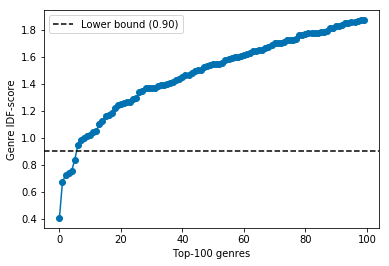

In [29]:
plt.plot(list(range(0, 100)), idf_scores_df.iloc[:100], "-o")
plt.xlabel("Top-100 genres")
plt.ylabel("Genre IDF-score")
plt.axhline(y=0.9, linestyle="--", color="black", label="Lower bound (0.90)")
plt.legend()
plt.grid(False)
plt.show()

# Basic statistics of BeyMS

In [30]:
too_general_genres = idf_scores_df[idf_scores_df["idf"] < 0.9].index.unique().tolist()
too_general_genres

['rock', 'pop', 'metal', 'electronic', 'alternativerock', 'indierock']

In [31]:
df = beyms_genre_annotations_df.copy()
df["genres"] = df["genres"].apply(lambda genres: [g for g in genres if g not in too_general_genres])
more_specific_tracks_df = df[df["genres"].apply(len) != 0]

In [32]:
beyms_tracks = more_specific_tracks_df.index.unique().tolist()

In [33]:
len(beyms_tracks)

157444

In [34]:
more_specific_events_df = events_df[(events_df["track_id"].isin(beyms_tracks)) & (events_df["user_id"].isin(beyms))]
more_specific_events_df.head()

,user_id,artist_id,album_id,track_id,timestamp
0,31435741,21,31,53,1370977938
1,31435741,21,31,53,1370977728
2,31435741,21,31,53,1370977518
3,31435741,21,31,53,1370977308
4,31435741,21,31,53,1370977098


In [35]:
len(more_specific_events_df)

4916174

In [36]:
n_users = len(beyms)
n_tracks = len(beyms_tracks)
n_artists = more_specific_events_df["artist_id"].nunique()
n_LEs = len(more_specific_events_df)

In [37]:
groupby_beyms = more_specific_events_df.groupby("user_id")
min_LEs_per_user = groupby_beyms.size().describe().loc["min"]
q1_LEs_per_user = groupby_beyms.size().describe().loc["25%"]
median_LEs_per_user = groupby_beyms.size().describe().loc["50%"]
q3_LEs_per_user = groupby_beyms.size().describe().loc["75%"]
max_LEs_per_user = groupby_beyms.size().describe().loc["max"]
mean_LEs_per_user = groupby_beyms.size().describe().loc["mean"]
std_LEs_per_user = groupby_beyms.size().describe().loc["std"]

In [38]:
beyms_countries_df = pd.read_csv("data/LFM-1b_users.txt", sep="\t")[["user_id", "country"]].set_index("user_id").dropna().loc[beyms]
beyms_countries_df.head()

,country
user_id,
1049656,FI
1055118,US
1056935,UK
1070023,US
1072752,DK


In [39]:
mean_users_per_country = beyms_countries_df["country"].value_counts().mean()
std_users_per_country = beyms_countries_df["country"].value_counts().std()

In [40]:
print("Users: %d" % n_users)
print("Tracks: %d" % n_tracks)
print("Artists: %d" % n_artists)
print("Listening Events (LEs): %d" % n_LEs)
print("Min. LEs per user: %d" % min_LEs_per_user)
print("Q1 LEs per user: %d" % q1_LEs_per_user)
print("Median LEs per user: %d" % median_LEs_per_user)
print("Q3 LEs per user: %d" % q3_LEs_per_user)
print("Max. LEs per user: %d" % max_LEs_per_user)
print("Mean (Std) LEs per user: %f (%f)" % (mean_LEs_per_user, std_LEs_per_user))
print("Mean (Std) Users per country: %f (%f)" % (mean_users_per_country, std_users_per_country))

Users: 2074
Tracks: 157444
Artists: 14922
Listening Events (LEs): 4916174
Min. LEs per user: 3
Q1 LEs per user: 1254
Median LEs per user: 2048
Q3 LEs per user: 3239
Max. LEs per user: 10536
Mean (Std) LEs per user: 2371.526290 (1520.628757)
Mean (Std) Users per country: 44.127660 (77.669483)


# Save dataset for BeyMS and MS

In [41]:
# The dataset comprises tracks that have been listened by at least one user in BeyMS.
# Each track is annotated with more-specific genres and its representation by acoustic features can be obtained.

In [42]:
more_specific_tracks_df.to_csv("data/beyms_more_specific_tracks.csv")

In [43]:
idf_scores_df.reset_index().rename(columns={"index": "genre"}).to_csv("data/genre_idf_scores.csv", index=False)

In [44]:
beyms_df = pd.DataFrame(beyms)
beyms_df.columns = ["user_id"]
beyms_df.to_csv("data/beyms.csv", index=False)

In [45]:
ms_df = pd.DataFrame(ms)
ms_df.columns = ["user_id"]
ms_df.to_csv("data/ms.csv", index=False)

In [46]:
events_df.to_csv("data/events.csv", index=False)

In [47]:
more_specific_events_df.to_csv("data/more_specific_events.csv", index=False)